# Spectrogram Emotion Prototype Learning

*Code fully written by Daniel Peña Porras*.



---


*    #### Training and evaluation of **PROTOTYPE CLASSIFIER** with:

    *    Prototype layer
    *    Fully-connected layer and softmax activation
    *    2-term (classification-similarity) loss function



---


In [ ]:
'''
@author: Daniel Peña Porras.
'''

'\n@author: Daniel Peña Porras.\n'

##### Dependencies

In [ ]:
! pip install librosa
! pip install mir_eval

In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

2025-05-14 07:25:55.196750: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
import os

import librosa
import librosa.display as dsp

import mir_eval

from IPython.display import Audio

import matplotlib.pyplot as plt
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn import preprocessing

from skimage.transform import resize
from scipy.ndimage import gaussian_laplace

from keras.callbacks import TensorBoard

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LeakyReLU, BatchNormalization, ActivityRegularization#, Sigmoid
import os
from keras import backend as K
from tensorflow.keras.utils import plot_model, model_to_dot
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback

from skimage.transform import resize
from keras.callbacks import Callback
from keras.applications import VGG19, EfficientNetB0, ResNet50V2, DenseNet121
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Concatenate
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

from scipy.ndimage import gaussian_laplace

from scipy.io import wavfile

from keras.constraints import NonNeg,UnitNorm
from keras.initializers import Constant

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd

In [ ]:
os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
!pip install reportlab

from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Image, Preformatted
from reportlab.lib.styles import getSampleStyleSheet
import datetime

from reportlab.platypus import Spacer
from reportlab.lib.units import inch
from reportlab.lib.utils import ImageReader

In [ ]:
import seaborn as sns

##### Hyperparameters

In [ ]:
"""
DATA PARAMETERS
"""
#prepocess_window_size_ms = 100
#preprocess_window_overlapping_ms = 20
test_prctg = 0.3

dataset = 'EmoMatch' # or 'EmoDB' 'RAVDESS'

dtype = 'float32'
n_frames_cnn = None #128 established after data loading
n_freq_cnn = None #20 established after data loading
n_color_channels = 1

#same parameters as in preprocessing
n_fft = 1024            # length of the FFT window
window = 'hamming'      # window function
win_length = 512        # window length
hop_length = 256        # number of samples between successive frames
n_mels = 128

In [ ]:
if dataset == 'RAVDESS':
    sr = 48000
    n_speakers = 24
    speakers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
    n_phonemes = 44
    n_classes = 8
    class_names = [
        'neutral',
        'calm',
        'happy',
        'sad',
        'angry',
        'fearful',
        'disgust',
        'surprised'
    ]
    get_prototype_emotion = {
        0: 'neutral',
        1: 'calm',
        2: 'joy',
        3: 'sadness',
        4: 'anger',
        5: 'fear',
        6: 'disgust',
        7: 'surprise'
    }
    male_speakers = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]
    female_speakers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]

elif dataset == 'EmoMatch':
    sr = 48000
    # n_speakers = 50
    speakers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20, 22, 23,
                25, 29, 31, 33, 35, 36, 37, 40, 41, 43, 45, 46, 49]
    n_speakers = len(speakers)
    n_phonemes = 24
    n_classes = 7
    class_names = [
        'angry',
        'disgust',
        'fearful',
        'happy',
        'neutral',
        'sad',
        'surprised'
    ]
    get_prototype_emotion = {
        0: 'anger',
        1: 'disgust',
        2: 'fear',
        3: 'joy',
        4: 'neutral',
        5: 'sadness',
        6: 'surprise'
    }
    male_speakers = [1, 2, 5, 9, 12, 13, 22, 23, 31, 35, 36, 37, 43]
    female_speakers = [3, 4, 6, 7, 8, 10, 11, 20, 25, 29, 33, 40, 41, 45, 46, 49]

elif dataset == 'EmoDB':
    sr = 16000
    n_speakers = 10
    speakers = [3, 8, 9, 10, 11, 12, 13, 14, 15, 16]
    n_phonemes = 45
    n_classes = 7
    class_names = [
        'angry',
        'bored',
        'disgust',
        'fearful',
        'happy',
        'neutral',
        'sad'
    ]
    get_prototype_emotion = {
        0: 'angry',
        1: 'bored',
        2: 'disgust',
        3: 'fearful',
        4: 'happy',
        5: 'neutral',
        6: 'sad'
    }
    male_speakers = [3, 10, 11, 12, 15]
    female_speakers = [8, 9, 13, 14, 16]

fmax = sr/2
fmin = 0  # default value if not specified

In [ ]:
"""
PROTOTYPE-LEARNING CLASSIFIER HYPERPARAMETERS
"""

n_prototypes = n_phonemes * n_classes

design = 'similarity'
distance_measure = 'l4' # or 'euclidean', 'l2', 'l3', 'l4', 'l5'...

#logits_activation = 'softmax'
prototypes_initializer = 'uniform'
fullyconnected_initializer = 'random_normal'
fullyconnected_bias = False
fullyconnected_bias_initializer = 'zeros'

In [ ]:
"""
TRAINING HYPERPARAMETERS
"""

clasif_loss = 'focal' #'CCE'
simil_loss = 'focal' #'CCE'

if clasif_loss == 'focal':
    classification_loss = keras.losses.CategoricalFocalCrossentropy()
    clasif_loss_name = 'keras.losses.CategoricalFocalCrossentropy()'
elif clasif_loss == 'CCE':
    classification_loss = keras.losses.CategoricalCrossentropy()
    clasif_loss_name = 'keras.losses.CategoricalCrossentropy()'

if simil_loss == 'focal':
    similarity_loss = keras.losses.CategoricalFocalCrossentropy()
    simil_loss_name = 'keras.losses.CategoricalFocalCrossentropy()'
elif simil_loss == 'CCE':
    similarity_loss = keras.losses.CategoricalCrossentropy()
    simil_loss_name = 'keras.losses.CategoricalCrossentropy()'

classifier_batch_size = 512
classifier_epochs = 20000
classifier_learning_rate = 0.01

ratioPrototypesDisplay = 1000

lambdaS = 0.001
lambdaC = 1

classification_patience_epochs = 1000
classification_convergence = 0

##### Model and losses

In [ ]:
#@register_keras_serializable(package='Custom', name='PrototypeLayer')
class PrototypeLayer(layers.Layer):
    def __init__(self, units=n_prototypes, prototypes_initializer=prototypes_initializer, distance_measure=distance_measure, **kwargs):
        super(PrototypeLayer, self).__init__(**kwargs)
        self.units = units
        self.prototypes_initializer = prototypes_initializer
        self.distance_measure = distance_measure

    def build(self, input_shape):
      self.weight = self.add_weight(
          shape=(self.units, input_shape[-1]),
          initializer=prototypes_initializer,
          trainable=True,
          )

    def call(self, inputs):
        prototype_sim, prototype_sim_norm, prototype_sim_truth = calculate_similarity(inputs, self.weight, self.freq_dep_distance, self.distance_measure)
        self.prototype_sim = prototype_sim
        self.prototype_sim_truth = prototype_sim_truth
        return prototype_sim, prototype_sim_truth

    def get_config(self):
        config = super(PrototypeLayer, self).get_config()
        config.update({
            'units': self.units,
            'prototypes_initializer': self.prototypes_initializer,
            'distance_measure': self.distance_measure,
            # Do not include tensors directly in the config
            # Instead, include configurations that would allow them to be reconstructed
        })
        return config

    def get_prototypes(self):
        return self.weight

    def get_prototypes_shapes(self):
        return {"weights shape": self.weight.shape}

    def get_sims_shapes(self):
        return {"prototype_sim shape": self.prototype_sim.shape}

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [ ]:
#@register_keras_serializable(package='Custom', name='FullyConnected')
class FullyConnected(layers.Layer):
    def __init__(self, units=32, fullyconnected_initializer = 'random_normal', fullyconnected_bias = False, fullyconnected_bias_initializer = 'zeros', **kwargs):
        super(FullyConnected, self).__init__(**kwargs)
        self.units = units
        self.fullyconnected_initializer = fullyconnected_initializer
        self.fullyconnected_bias = fullyconnected_bias
        self.fullyconnected_bias_initializer = fullyconnected_bias_initializer

    def build(self, input_shape):
        self.weight = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=fullyconnected_initializer,
            trainable=True,
        )
        if self.fullyconnected_bias:
            self.bias = self.add_weight(
                shape=(self.units,), initializer=fullyconnected_bias_initializer, trainable=True
            )

    def call(self, inputs):
        if self.fullyconnected_bias:
            return tf.matmul(inputs, self.weight) + self.bias
        else:
            return tf.matmul(inputs, self.weight)

    def get_config(self):
        config = super().get_config()
        config.update({'units': self.units})
        return config

In [ ]:
def calculate_similarity(X, Y, distance_measure='euclidean'):
    """
    Compute similarity measures and corresponding masks between X and Y.

    Args:
        X: Tensor of shape (BS, dim)
        Y: Tensor of shape (dim, num_prt)
        distance_measure: One of {'euclidean', 'l2', 'l3', ..., 'l8'}

    Returns:
        similarity_scores: raw similarities
        normalized_similarity_scores: scaled to [0, 1]
        mask: one-hot mask where the highest similarity per row is 1
    """
    XX = tf.reduce_sum(tf.square(X), axis=1, keepdims=True)
    YY = tf.reduce_sum(tf.square(Y), axis=0, keepdims=True)
    distances = XX + YY - 2 * tf.matmul(X, Y)

    distances = tf.maximum(distances, 0.0)

    if distance_measure == 'euclidean' or distance_measure == 'l2':
        distances = tf.sqrt(distances)
    elif distance_measure.startswith('l'):
        try:
            p = int(distance_measure[1:])
            if p > 2:
                distances = tf.pow(distances, 1.0 / p)
        except ValueError:
            raise ValueError(f"Invalid distance_measure: {distance_measure}")

    similarity_scores = tf.exp(-distances)
    normalized_similarity_scores = similarity_scores / tf.reduce_max(similarity_scores)

    max_vals = tf.reduce_max(normalized_similarity_scores, axis=1, keepdims=True)
    mask = tf.cast(tf.equal(normalized_similarity_scores, max_vals), tf.float32)

    return similarity_scores, normalized_similarity_scores, mask

In [ ]:
def get_mean_prototype_score(weights_transposed, scoring_method=2):

  if scoring_method == 0:
    new_weights = weights
    positive_sums = np.sum(np.maximum(new_weights, 0), axis=1)

    for i, row in enumerate(new_weights):
      if positive_sums[i] > 0:
        row[row < 0] = 0  # Set negative values to 0
        row[row > 0] = (row[row > 0] / positive_sums[i]) * 100
      else:
        row[:] = 0
    new_weights_aux = new_weights
    custom_accuracies = np.array([np.max(row) for row in new_weights])

  elif scoring_method == 1:
    new_weights = weights
    new_weights_aux = np.zeros_like(new_weights)
    for i, row in enumerate(new_weights):
      min_val = np.min(row)
      shifted_row = row - min_val  # desplazamos para que el mínimo sea 0
      sum_shifted = np.sum(shifted_row)
      if sum_shifted > 0:
        new_row = (shifted_row / sum_shifted) * 100  # normalizamos y pasamos a %
      else:
        new_row = np.zeros_like(row)  # si todo es constante, ponemos 0
      new_weights_aux[i] = new_row
    custom_accuracies = np.array([np.max(row) for row in new_weights_aux])

  elif scoring_method == 2:
    new_weights = weights
    new_weights_aux = np.zeros_like(new_weights, dtype=float)
    for i, row in enumerate(new_weights):
      # shift logits for numerical stability
      exp_row = np.exp(row - np.max(row))
      softmax_row = exp_row / np.sum(exp_row)
      new_weights_aux[i] = softmax_row * 100  # convert to %
    custom_accuracies = np.array([np.max(row) for row in new_weights_aux])

  mean_custom_accuracy = np.mean(custom_accuracies) * 0.01
  return mean_custom_accuracy

##### Functions

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', num_classes=None, average='macro', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.average = average

        self.true_positives = [self.add_weight(name=f'tp_{i}', initializer='zeros') for i in range(num_classes)]
        self.false_positives = [self.add_weight(name=f'fp_{i}', initializer='zeros') for i in range(num_classes)]
        self.false_negatives = [self.add_weight(name=f'fn_{i}', initializer='zeros') for i in range(num_classes)]

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)

        for i in range(self.num_classes):
            y_true_i = tf.equal(y_true, i)
            y_pred_i = tf.equal(y_pred, i)

            tp = tf.reduce_sum(tf.cast(tf.logical_and(y_true_i, y_pred_i), self.dtype))
            fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(y_true_i), y_pred_i), self.dtype))
            fn = tf.reduce_sum(tf.cast(tf.logical_and(y_true_i, tf.logical_not(y_pred_i)), self.dtype))

            self.true_positives[i].assign_add(tp)
            self.false_positives[i].assign_add(fp)
            self.false_negatives[i].assign_add(fn)

    def result(self):
        precision = []
        recall = []
        f1_scores = []

        for i in range(self.num_classes):
            tp = self.true_positives[i]
            fp = self.false_positives[i]
            fn = self.false_negatives[i]

            p = tf.math.divide_no_nan(tp, tp + fp)
            r = tf.math.divide_no_nan(tp, tp + fn)
            f1 = tf.math.divide_no_nan(2 * p * r, p + r)

            precision.append(p)
            recall.append(r)
            f1_scores.append(f1)

        f1_scores = tf.stack(f1_scores)

        if self.average == 'macro':
            return tf.reduce_mean(f1_scores)
        elif self.average == 'micro':
            total_tp = tf.reduce_sum(self.true_positives)
            total_fp = tf.reduce_sum(self.false_positives)
            total_fn = tf.reduce_sum(self.false_negatives)
            p = tf.math.divide_no_nan(total_tp, total_tp + total_fp)
            r = tf.math.divide_no_nan(total_tp, total_tp + total_fn)
            return tf.math.divide_no_nan(2 * p * r, p + r)
        else:
            return f1_scores  # per class

    def reset_state(self):
        for v in self.true_positives + self.false_positives + self.false_negatives:
            v.assign(0.0)

In [ ]:
def save_learning_curve(epoch, path, train_losses, simil_losses, clf_losses,
                        train_clasif_accs, test_clasif_accs, train_clasif_f1s,
                        test_clasif_f1s, mean_proto_scores):
    epochs_range = range(epoch)
    plt.figure(figsize=(12, 6))

    # Plot losses
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, train_losses, label='Combined Training Loss')
    #plt.plot(epochs_range, simil_losses, label='Similarity Training Loss')
    plt.plot(epochs_range, clf_losses, label='Classification Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, train_clasif_accs, label='Training Accuracy')
    plt.plot(epochs_range, test_clasif_accs, label='Validation Accuracy')
    plt.plot(epochs_range, train_clasif_f1s, label='Training F1-Score')
    plt.plot(epochs_range, test_clasif_f1s, label='Validation F1-Score')
    plt.plot(epochs_range, mean_proto_scores, label='Mean Prototype Score')
    plt.title('Accuracy and F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(path)

In [ ]:
def class_accuracy(conf_matrix):
    diagonal = np.diag(conf_matrix)
    class_accuracy = diagonal / conf_matrix.sum(axis=1)
    return class_accuracy

In [ ]:
def create_pdf_report_params():
    model_name = f"Prototype Classifier Speaker {speaker}"

    weights_transposed = best_weights
    mean_custom_score = get_mean_prototype_score(weights_transposed)

    summary_params = {
        'Classification accuracy': f"{best_class_acc.numpy():.4f}",
        'Classification f1 score': f"{best_class_f1.numpy():.4f}",
        'Mean PROTOTYPE score': f"{mean_custom_score:.4f}",
    }

    clasif_losses_params = {
        'Primary Classification Loss': clasif_loss_name,
        'Prototype Similarity Loss': simil_loss_name,
        '\u03BB_C': lambdaC,
        '\u03BB_S': lambdaS
    }

    params = {
        'epochs': epoch,
        'batch_size': classifier_batch_size,
        'learning_rate': classifier_learning_rate,
        'optimizer': optimizer_name
    }

    classification_results = {
        'TRAIN accuracy': train_acc.numpy(),
        'TRAIN f1 score': train_f1.numpy(),
        'TEST accuracy': best_class_acc.numpy(),
        'TEST f1 score': best_class_f1.numpy()
    }

    prototype_results = {
        'Mean PROTOTYPE score': mean_custom_score,
    }

    return model_name, summary_params, clasif_losses_params, params, classification_results, prototype_results

In [ ]:
def resize_image(image_path, max_width=400, max_height=400):
    img_reader = ImageReader(image_path)
    img_width, img_height = img_reader.getSize()

    # Calculate aspect ratio
    aspect_ratio = img_width / img_height

    if img_width > max_width:
        img_width = max_width
        img_height = max_width / aspect_ratio
    if img_height > max_height:
        img_height = max_height
        img_width = max_height * aspect_ratio

    return img_width, img_height

In [ ]:
def save_confusion_matrix(conf_matrix, classes, confusion_matrix_path):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig(confusion_matrix_path)

In [ ]:
def create_pdf_report(model_name, speaker, dataset,
                      n_protos, summary_params, clasif_losses_params, params,
                      classification_results, prototype_results, learning_curve_path_2,
                      confusion_matrix_path, class_acc, overall_acc, class_names,
                      classification_report_text, output_path):

    pdf = SimpleDocTemplate(output_path, pagesize=letter)
    elements = []

    styles = getSampleStyleSheet()
    title_style = styles['Heading1']
    normal_style = styles['Normal']

    title = Paragraph(f"Training Report: {model_name}", title_style)
    elements.append(title)

    report_date = Paragraph(f"Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", normal_style)
    elements.append(report_date)

    elements.append(Spacer(1, 0.2 * inch))

    speaker_line = Paragraph(f"SPEAKER number: {speaker}", normal_style)
    elements.append(speaker_line)

    elements.append(Spacer(1, 0.2 * inch))

    nProtos_line = Paragraph(f"NUMBER OF PROTOTYPES: {n_protos}", normal_style)
    elements.append(nProtos_line)

    elements.append(Spacer(1, 0.2 * inch))

    nProtos_line = Paragraph(f"DATASET: {dataset}", normal_style)
    elements.append(nProtos_line)
#-----------------------------------------------------------------------------------------------------------
    elements.append(Paragraph("Results summary", styles['Heading2']))

    summary_param_data = [[key, str(value)] for key, value in summary_params.items()]
    summary_param_table = Table([["Parameter", "Value"]] + summary_param_data)
    summary_param_table.setStyle(TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.grey),
                                     ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                                     ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                                     ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                                     ('FONTSIZE', (0, 0), (-1, 0), 12),
                                     ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                                     ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                                     ('GRID', (0, 0), (-1, -1), 1, colors.black)]))
    elements.append(summary_param_table)
#-----------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------
    elements.append(Paragraph("Classification Loss Parameters", styles['Heading2']))

    clasif_loss_param_data = [[key, str(value)] for key, value in clasif_losses_params.items()]
    clasif_loss_param_table = Table([["Parameter", "Value"]] + clasif_loss_param_data)
    clasif_loss_param_table.setStyle(TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.grey),
                                     ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                                     ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                                     ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                                     ('FONTSIZE', (0, 0), (-1, 0), 12),
                                     ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                                     ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                                     ('GRID', (0, 0), (-1, -1), 1, colors.black)]))
    elements.append(clasif_loss_param_table)
#-----------------------------------------------------------------------------------------------------------
    elements.append(Paragraph("Training Parameters", styles['Heading2']))

    param_data = [[key, str(value)] for key, value in params.items()]
    param_table = Table([["Parameter", "Value"]] + param_data)
    param_table.setStyle(TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.grey),
                                     ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                                     ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                                     ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                                     ('FONTSIZE', (0, 0), (-1, 0), 12),
                                     ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                                     ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                                     ('GRID', (0, 0), (-1, -1), 1, colors.black)]))
    elements.append(param_table)
#-----------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------
    elements.append(Paragraph("Classification Results", styles['Heading2']))

    # Add second learning curve image
    learning_curve_img_2 = Image(learning_curve_path_2)
    img_width, img_height = resize_image(learning_curve_path_2)
    learning_curve_img_2.drawWidth = img_width
    learning_curve_img_2.drawHeight = img_height
    elements.append(learning_curve_img_2)

    clasif_result_data = [[key, str(value)] for key, value in classification_results.items()]
    clasif_result_table = Table([["Metric", "Value"]] + clasif_result_data)
    clasif_result_table.setStyle(TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.grey),
                                      ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                                      ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                                      ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                                      ('FONTSIZE', (0, 0), (-1, 0), 12),
                                      ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                                      ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                                      ('GRID', (0, 0), (-1, -1), 1, colors.black)]))
    elements.append(clasif_result_table)

    # Add confusion matrix image
    confusion_matrix_img = Image(confusion_matrix_path)
    img_width, img_height = resize_image(confusion_matrix_path)
    confusion_matrix_img.drawWidth = img_width
    confusion_matrix_img.drawHeight = img_height
    elements.append(confusion_matrix_img)
#-----------------------------------------------------------------------------------------------------------
    # Adding Class-wise Accuracy
    elements.append(Paragraph("Class-wise Accuracy", styles['Heading2']))

    class_acc_data = [[f"Class {i} ({class_names[i]})", f"{acc:.4f}"] for i, acc in enumerate(class_acc)]
    class_acc_data.append(["Overall Accuracy", f"{overall_acc:.4f}"])
    class_acc_table = Table([["Class", "Accuracy"]] + class_acc_data)
    class_acc_table.setStyle(TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.grey),
                                         ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                                         ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                                         ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                                         ('FONTSIZE', (0, 0), (-1, 0), 12),
                                         ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                                         ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                                         ('GRID', (0, 0), (-1, -1), 1, colors.black)]))
    elements.append(class_acc_table)

    #-----------------------------------------------------------------------------------------------------------
    # Adding the classification report as a paragraph
    elements.append(Paragraph("Classification Report", styles['Heading2']))
    # classification_report_paragraph = Paragraph(f"<pre>{classification_report_text}</pre>", normal_style)
    # elements.append(classification_report_paragraph)
    preformatted_report = Preformatted(report, style=normal_style)
    elements.append(preformatted_report)
#-----------------------------------------------------------------------------------------------------------
    elements.append(Paragraph("Prototype Results", styles['Heading2']))

    protos_result_data = [[key, str(value)] for key, value in prototype_results.items()]
    protos_result_table = Table([["Metric", "Value"]] + protos_result_data)
    protos_result_table.setStyle(TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.grey),
                                      ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                                      ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                                      ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                                      ('FONTSIZE', (0, 0), (-1, 0), 12),
                                      ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                                      ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                                      ('GRID', (0, 0), (-1, -1), 1, colors.black)]))
    elements.append(protos_result_table)
#-----------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------

    pdf.build(elements)
    print(f"PDF report generated: {output_path}")

## **Training and evaluation loop**



🔁 Training Classifier for Speaker 25...


2025-05-14 07:26:02.084423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


{'name': 'prototype_layer', 'trainable': True, 'dtype': 'float32', 'units': 168, 'use_weighted_sum': False, 'prototypes_initializer': 'uniform', 'freq_dep_distance': False, 'distance_measure': 'l4'}
{'weights shape': TensorShape([168, 2560])}
{'prototype_sim shape': TensorShape([None, 168])}
53/53 [==============================] - 0s 6ms/step

Epoch 0
Step 0: clasif loss = 1.9490
Step 0: simil loss = 0.0100
Step 0: loss = 1.9490
Train ACC: 0.2080 | test ACC: 0.2401
Train F1: 0.1018 | test F1: 0.0553
Mean PROTOTYPE score: 0.5142
Mean PROTOTYPE score MINMAX: 0.2822
6/6 [==============================] - 0s 12ms/step

Epoch 1000
Step 0: clasif loss = 1.4129
Step 0: simil loss = 0.0088
Step 0: loss = 1.4129
Train ACC: 0.4996 | test ACC: 0.4636
Train F1: 0.3072 | test F1: 0.2892
Mean PROTOTYPE score: 0.6112
Mean PROTOTYPE score MINMAX: 0.3396
6/6 [==============================] - 0s 11ms/step

Epoch 2000
Step 0: clasif loss = 1.3013
Step 0: simil loss = 0.0086
Step 0: loss = 1.3014
Train 

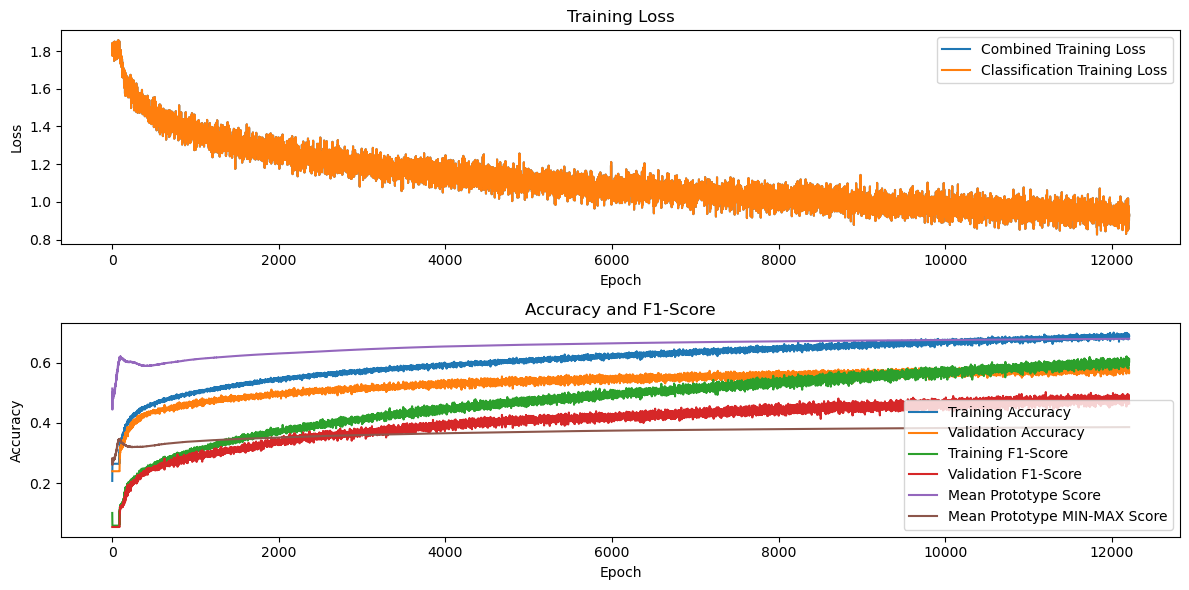

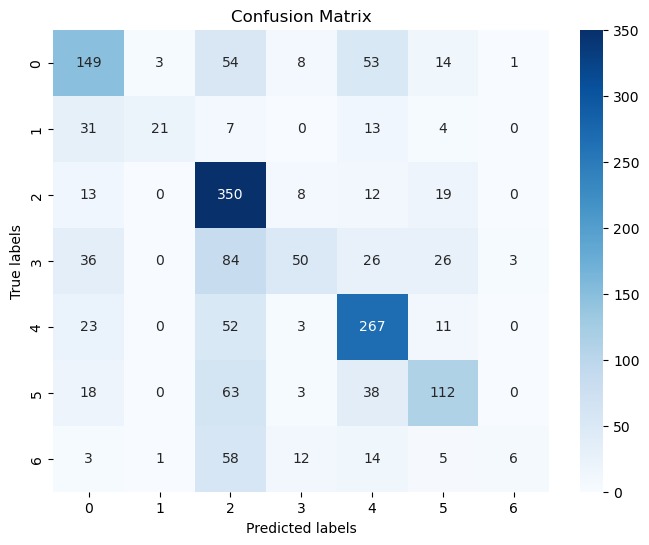

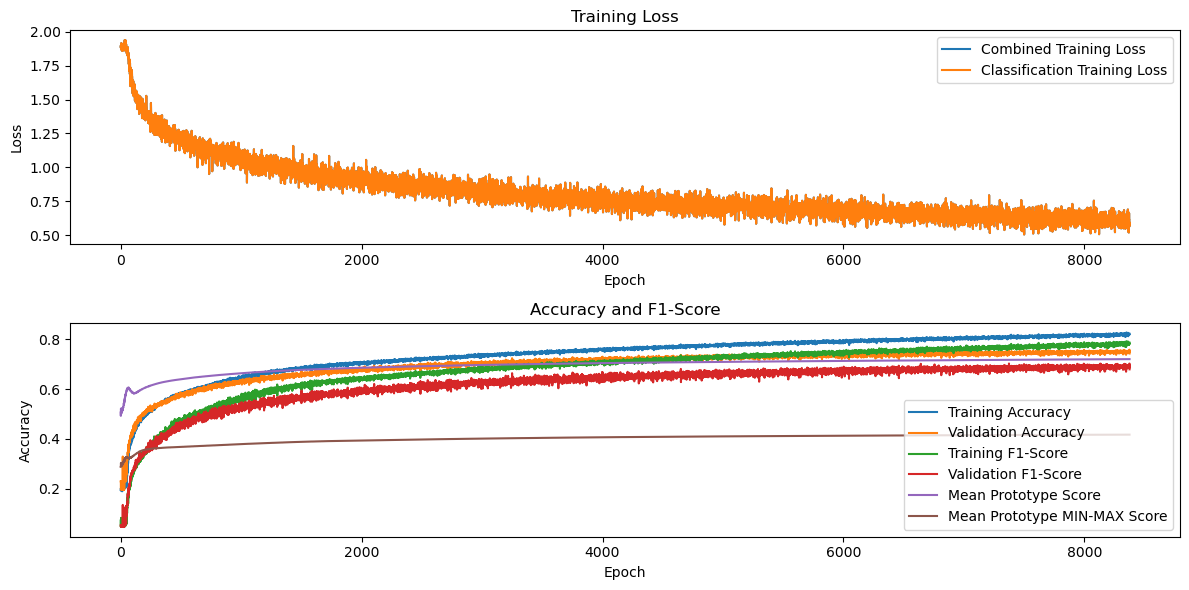

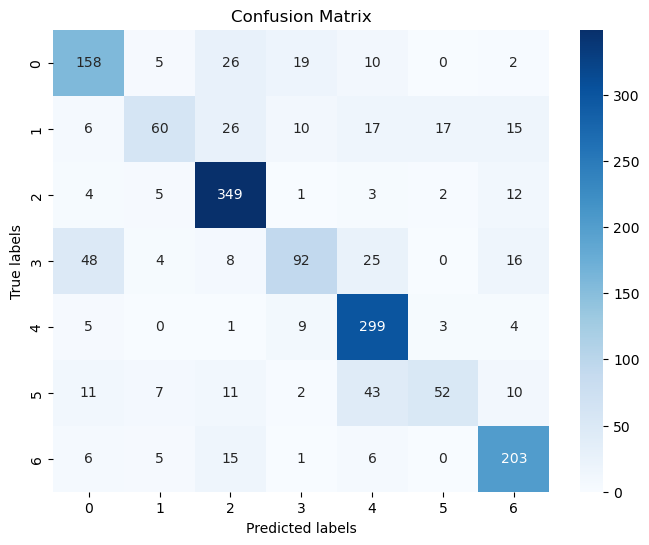

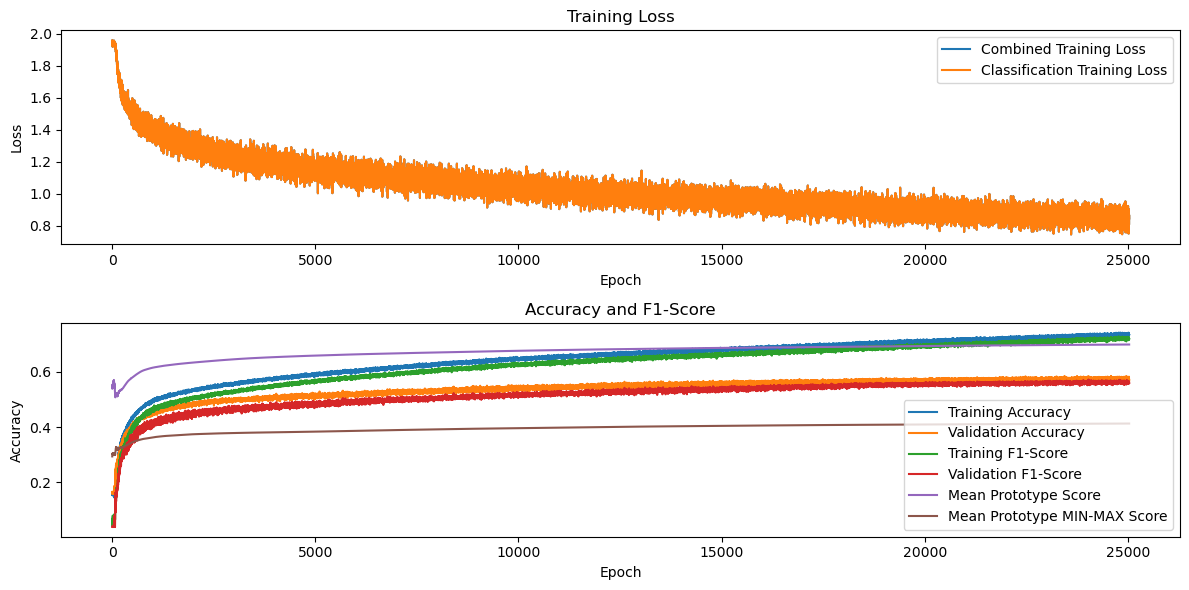

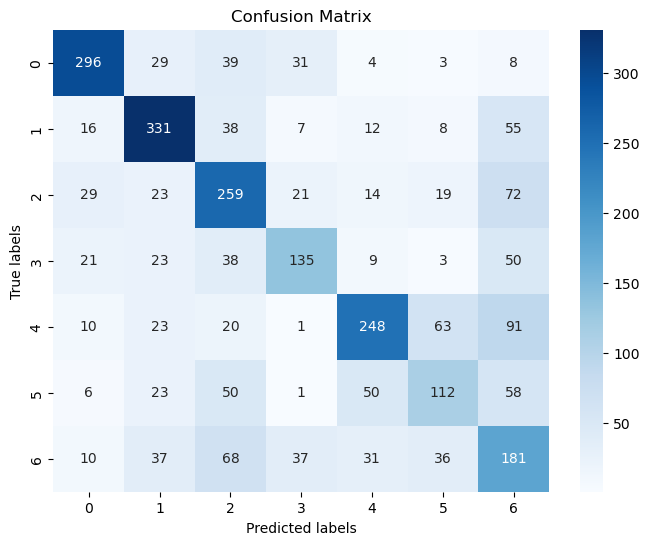

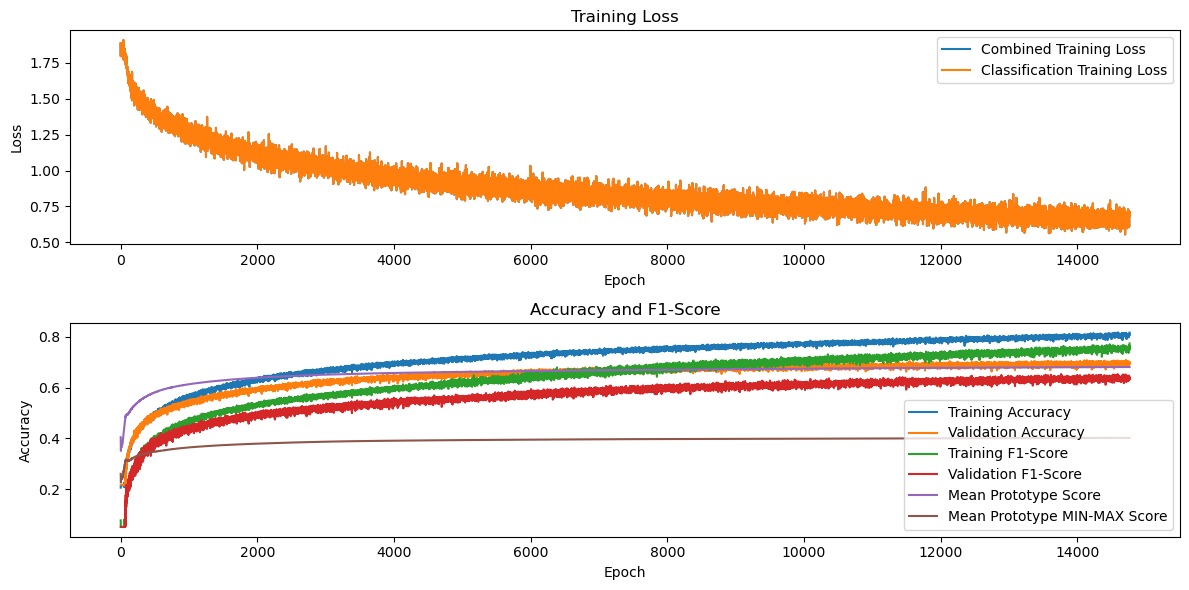

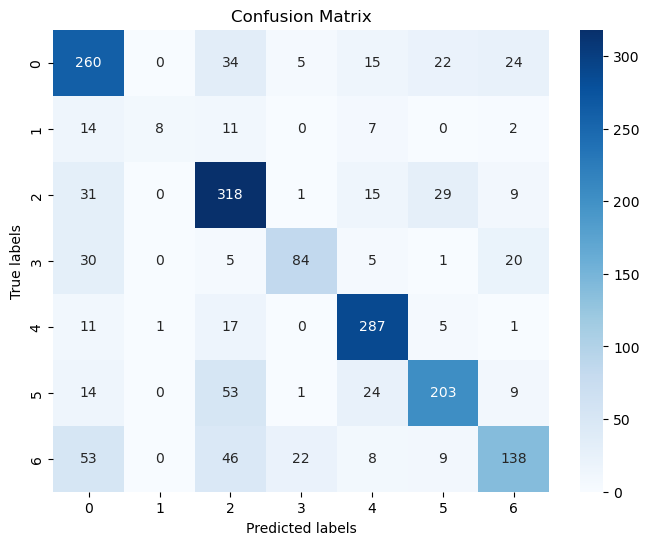

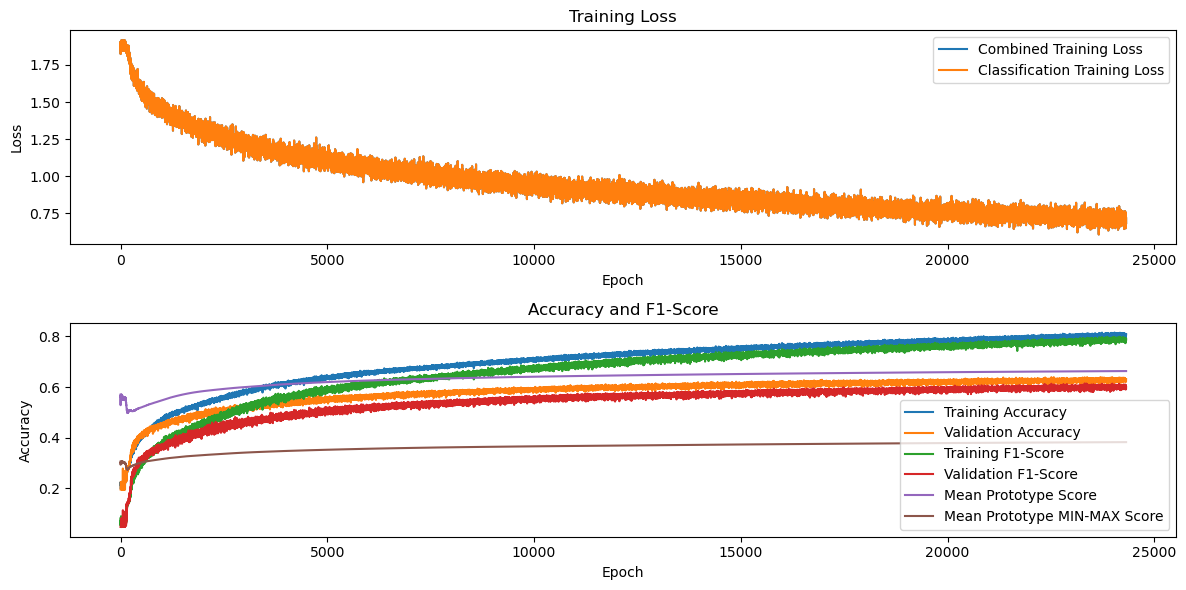

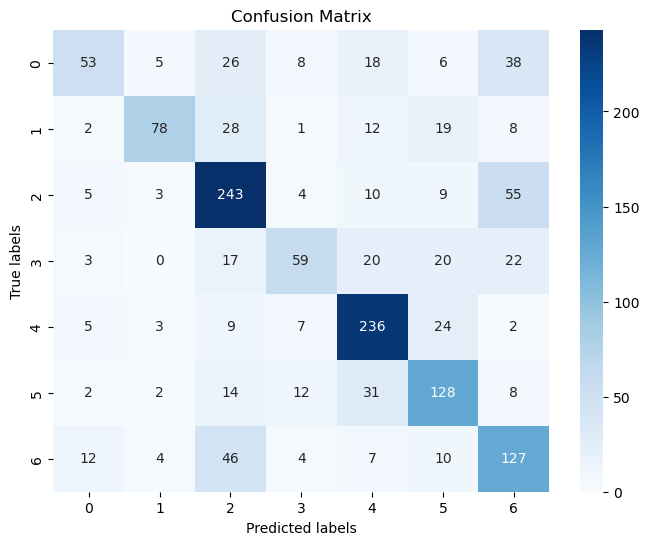

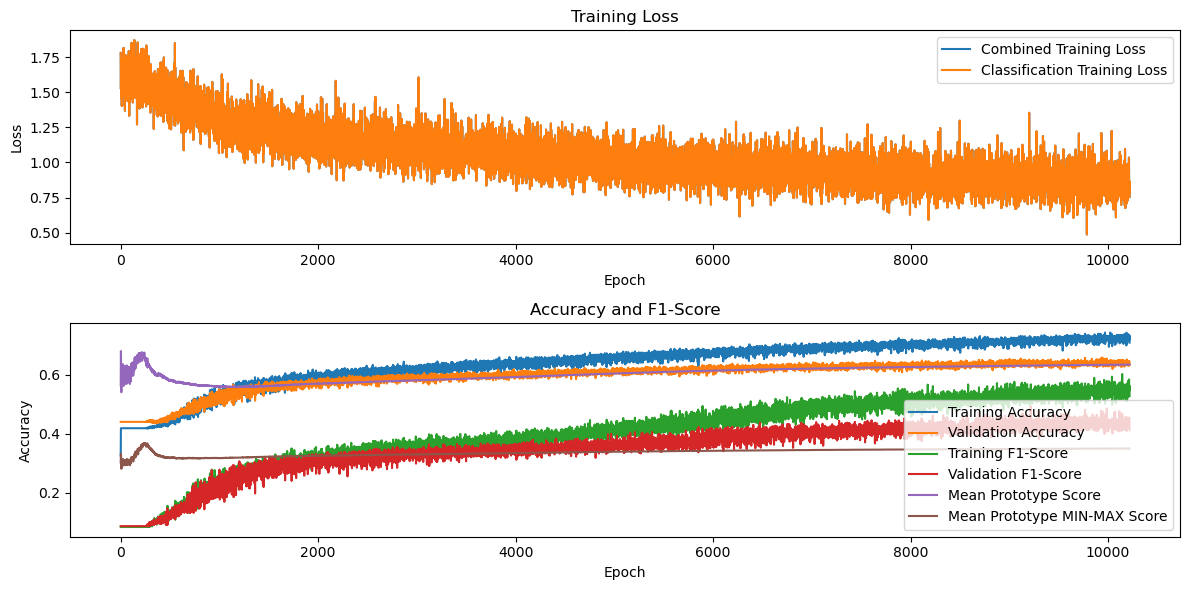

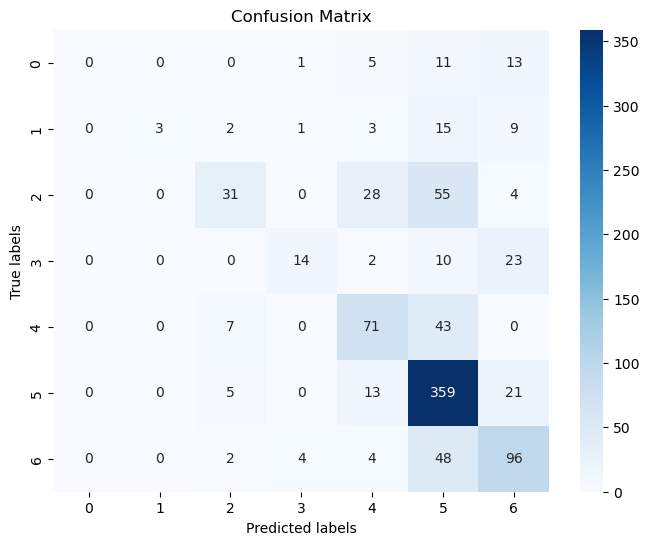

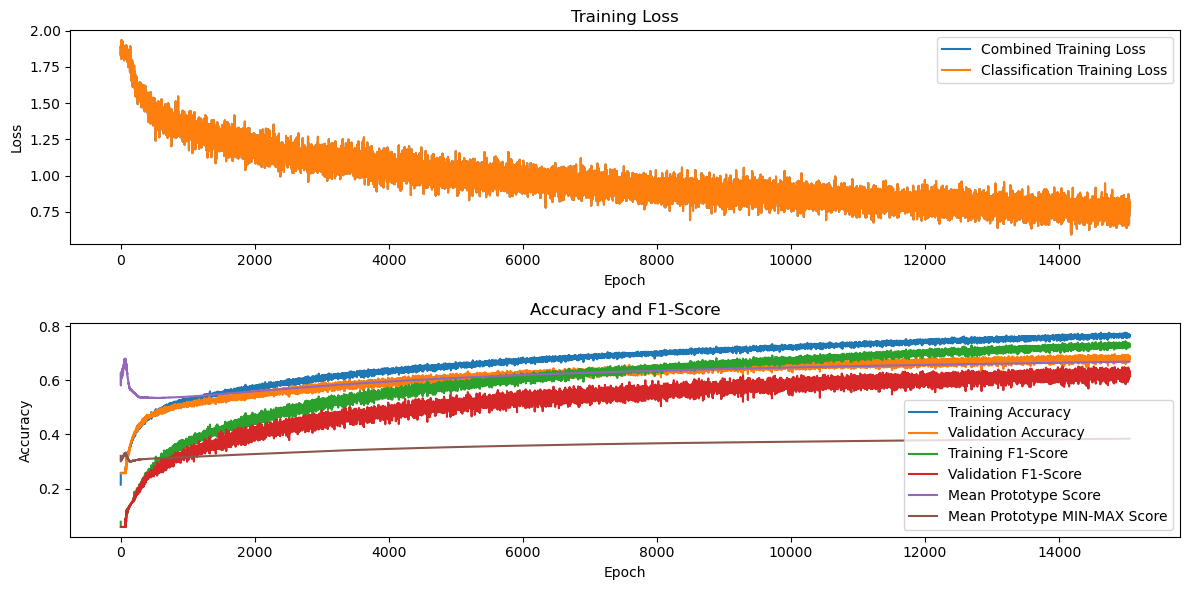

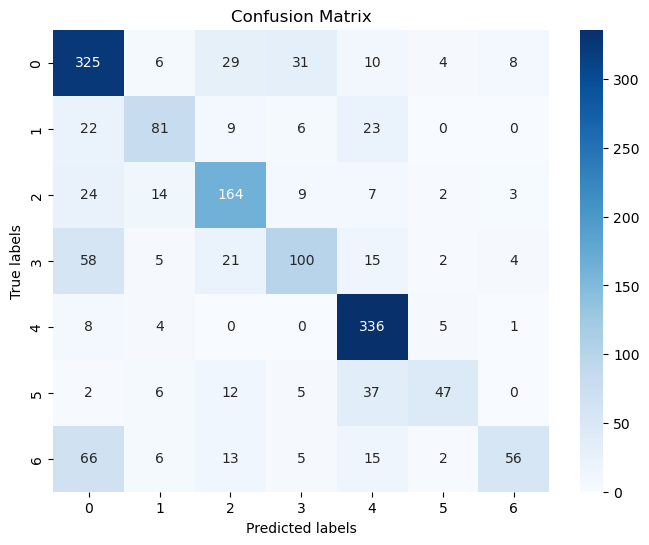

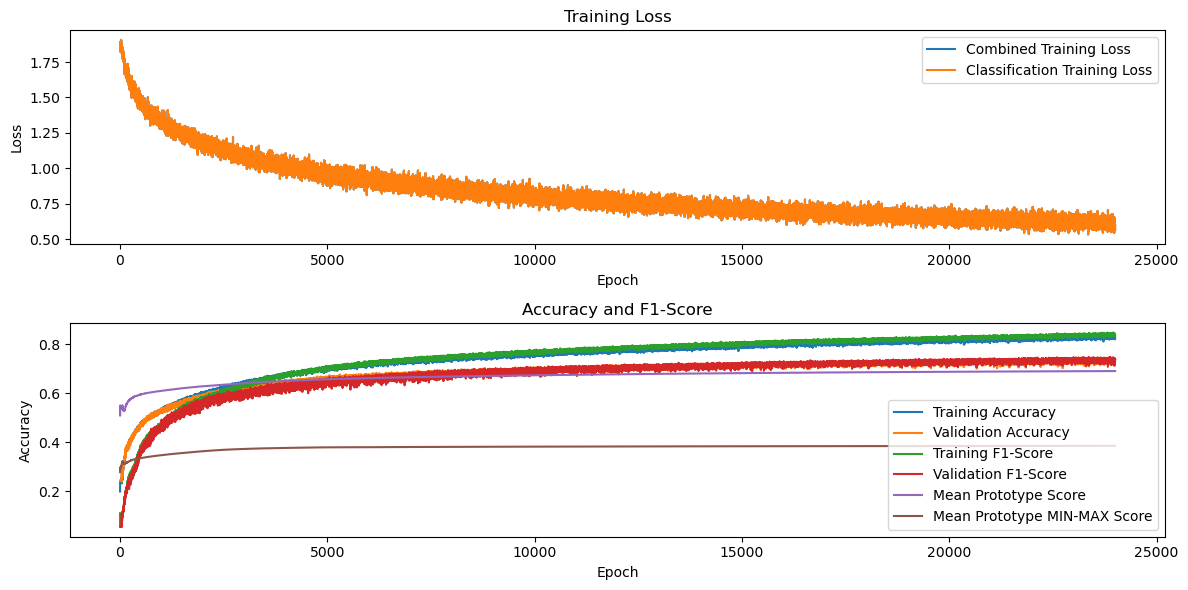

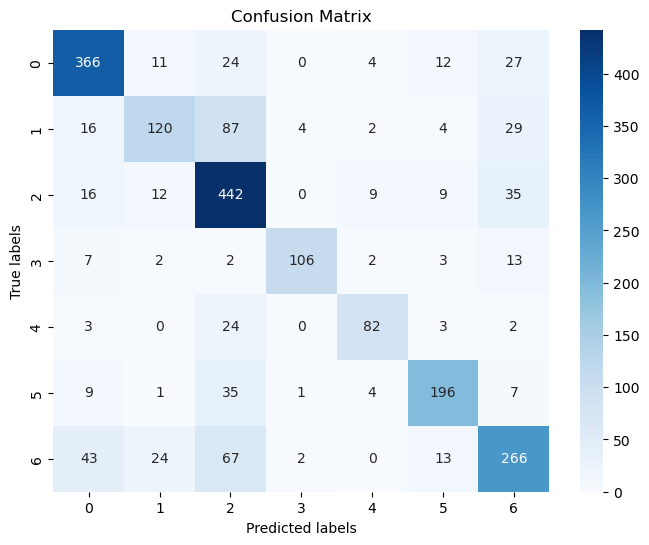

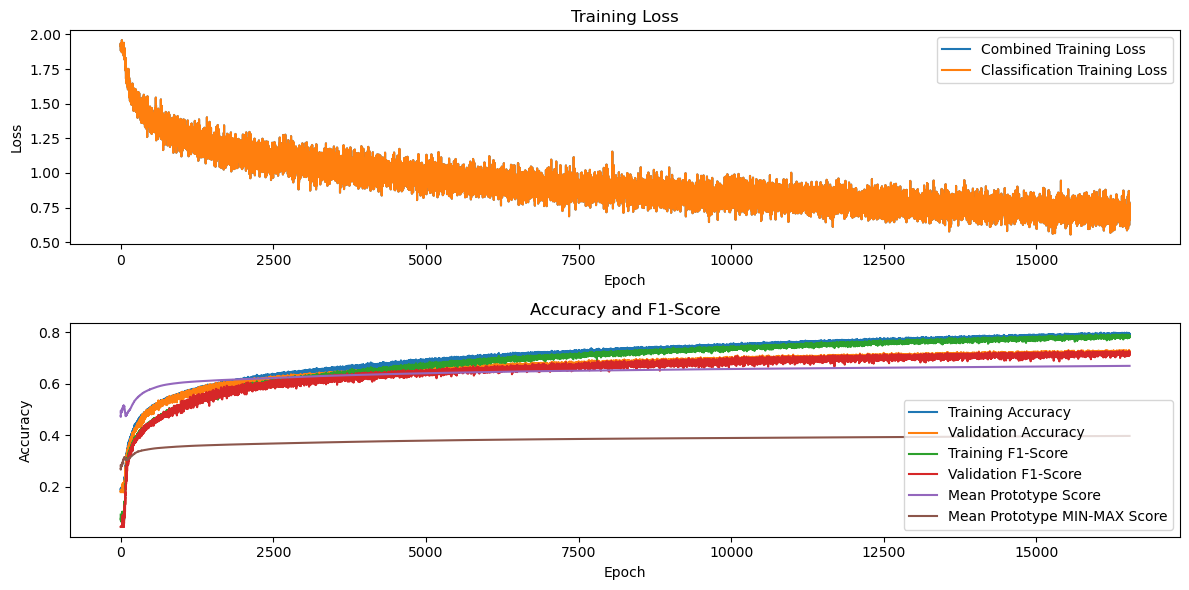

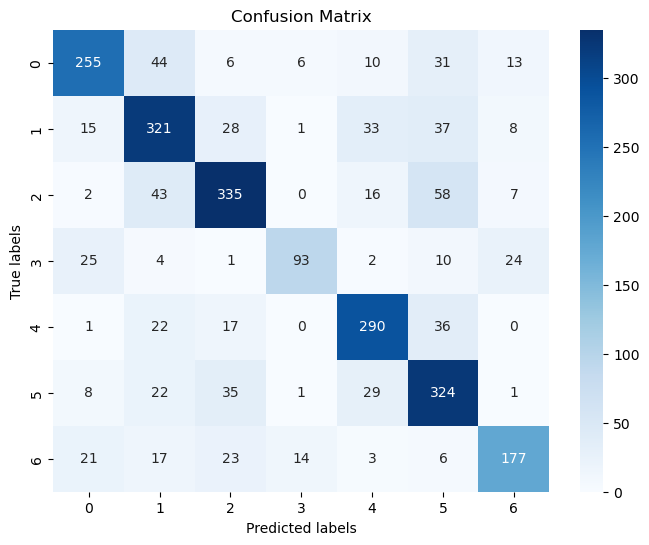

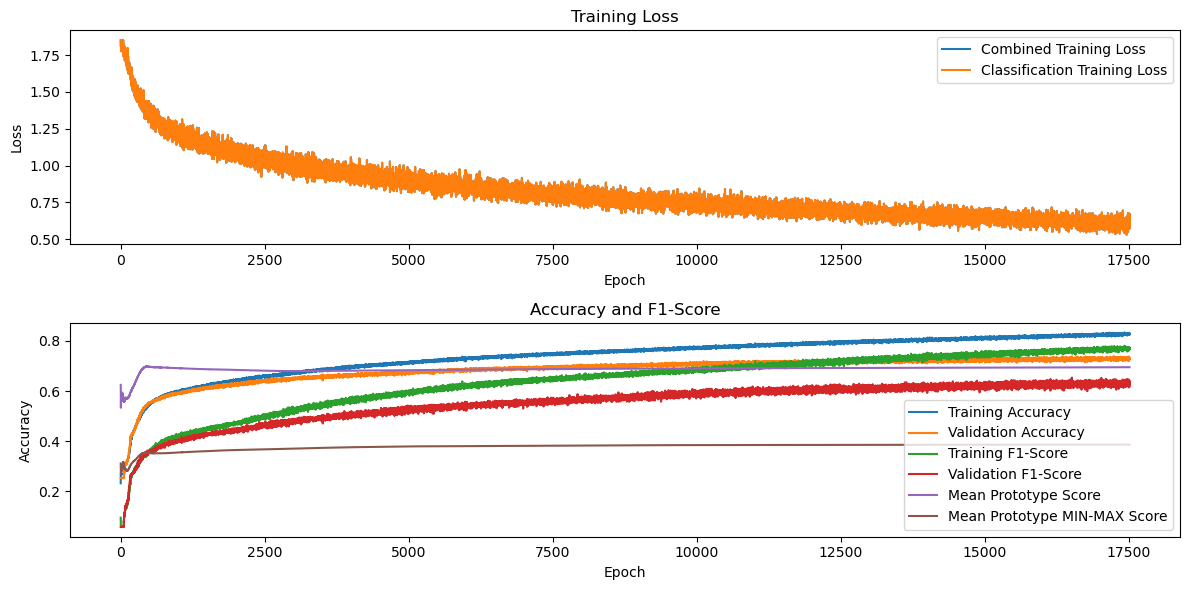

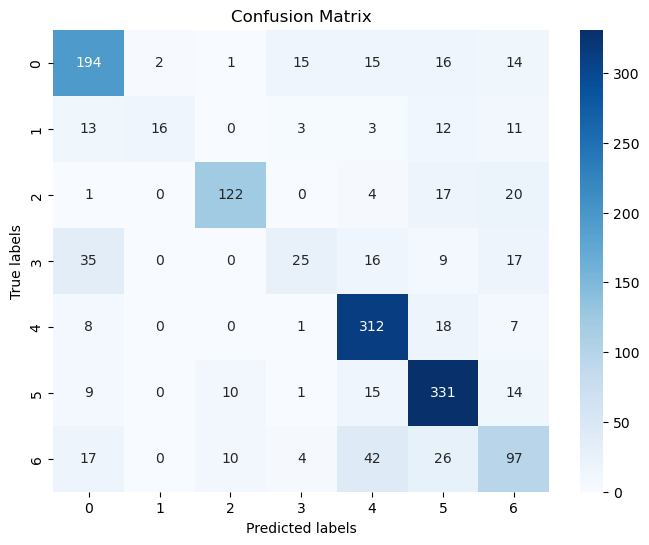

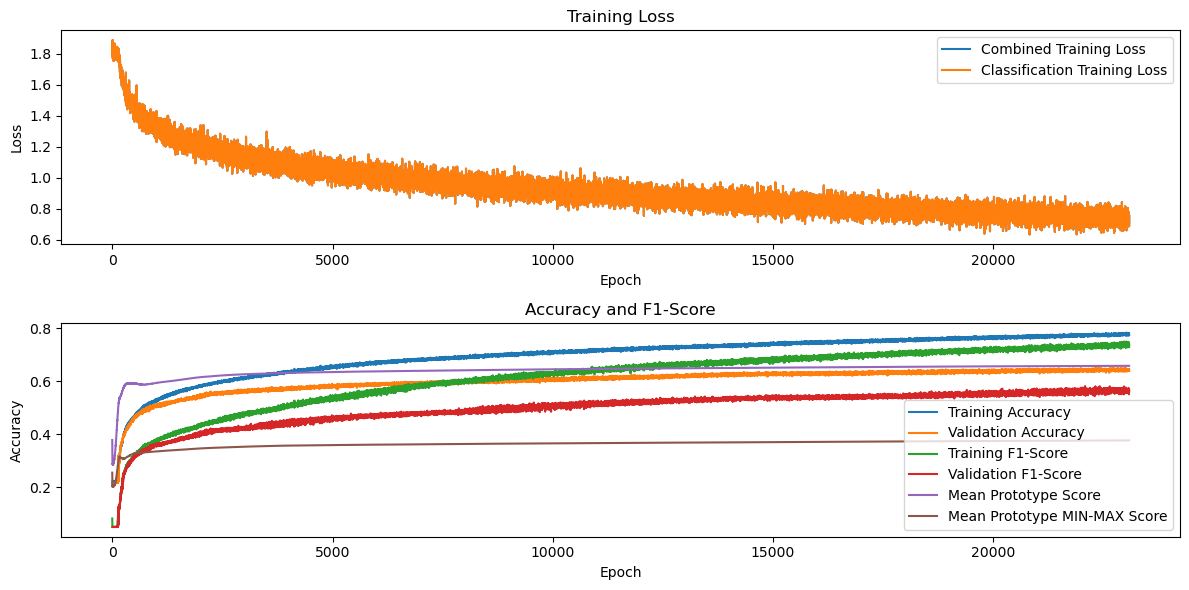

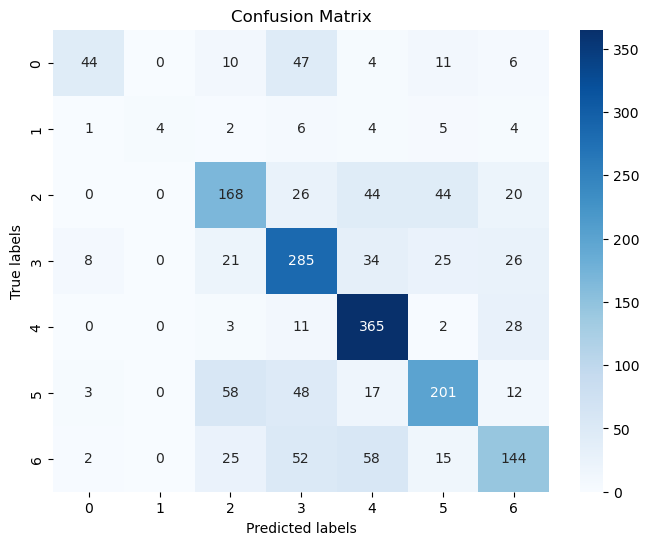

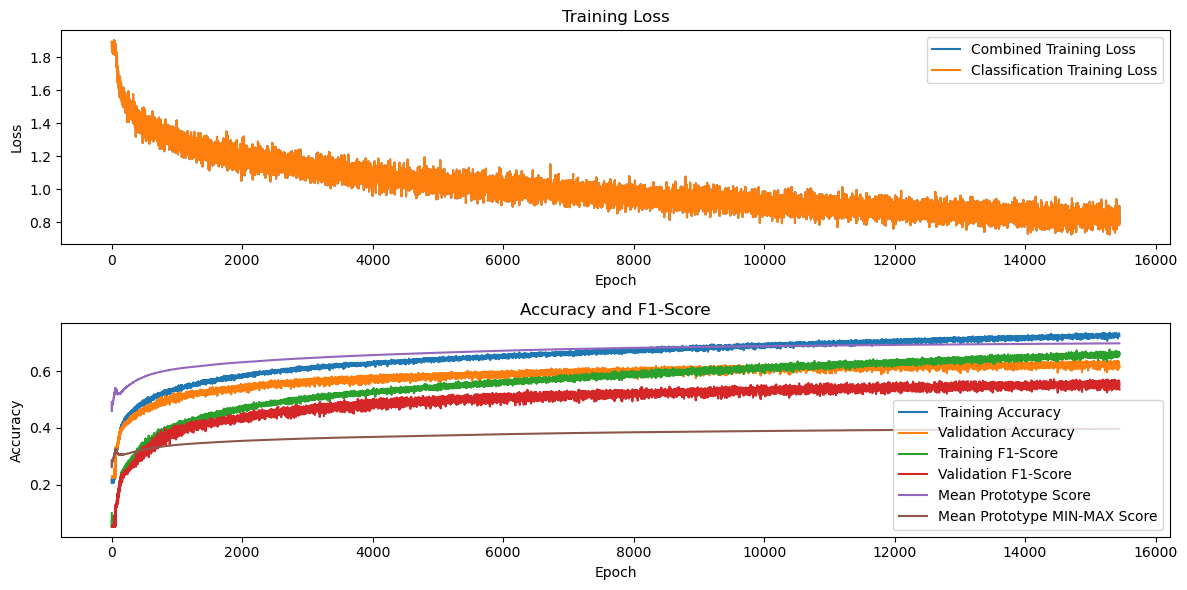

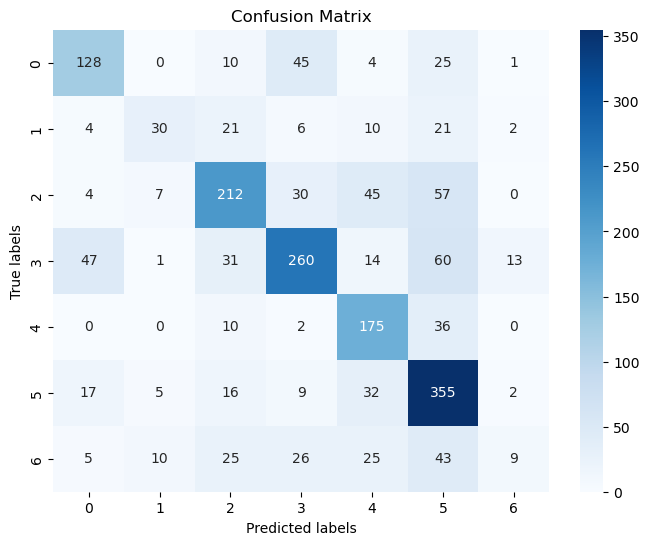

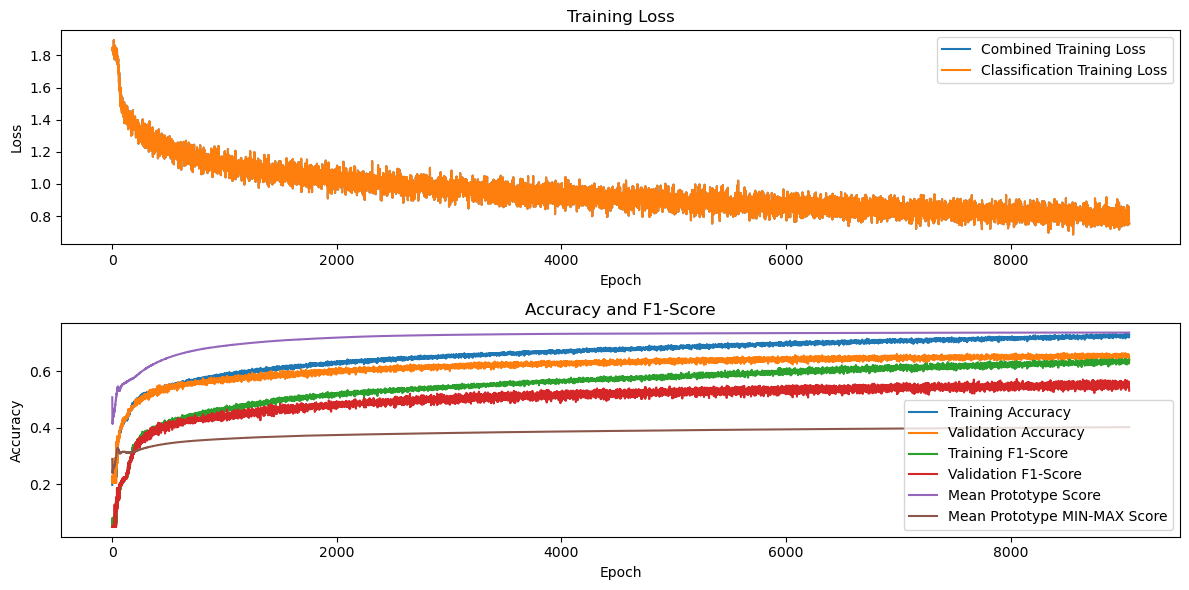

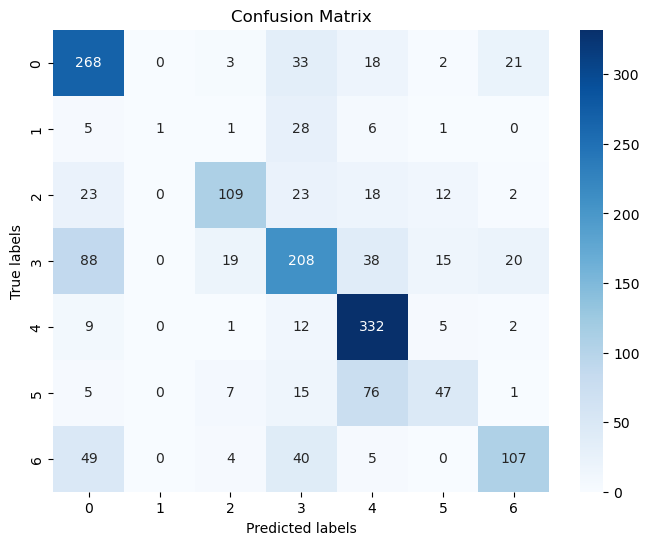

In [ ]:
results = []

for speaker_id in speakers:
    speaker = f"{speaker_id:02d}"  # format as '01', '02', ..., '50'
    print(f"\n\n🔁 Training Classifier for Speaker {speaker}...")

    # Define paths
    data_path = f'/home/jovyan/Daniel/Exp_{dataset}/datasets/{dataset}100ms32LabeledSpe{speaker}.npz'

    store_classifier_path = f'/home/jovyan/Daniel/Exp_{dataset}/classifiers_training/models/classifier_Speaker{speaker}.keras'
    store_prototypes_path = f'/home/jovyan/Daniel/Exp_{dataset}/classifiers_training/prototypes/prototypes_Speaker{speaker}.npz'
    store_weights_path = f'/home/jovyan/Daniel/Exp_{dataset}/classifiers_training/weights/weights_Speaker{speaker}.npz'
    confusion_matrix_path=f'/home/jovyan/Daniel/Exp_{dataset}/classifiers_training/evaluation/confusion_matrix_speaker{speaker}.png'
    learning_curve_path=f'/home/jovyan/Daniel/Exp_{dataset}/classifiers_training/evaluation/learning_curve_speaker{speaker}.png'

    # Load data
    data = np.load(data_path)
    x_train_100ms = data['x_train']
    y_train_100ms = data['y_emo']

    x_train, x_test, y_train, y_test = train_test_split(
        x_train_100ms, y_train_100ms, test_size=test_prctg, random_state=42)

    # Preprocessing
    min_norm = np.min(x_train)
    max_norm = np.max(x_train)

    x_train_norm = (x_train - min_norm) / (max_norm - min_norm)
    x_test_norm = (x_test - min_norm) / (max_norm - min_norm)

    # Load models
    store_AE_path = f'/home/jovyan/Daniel/Exp_{dataset}/autoencoders_training/models/autoencoder_Speaker{speaker}.keras'
    store_encoder_path = f'/home/jovyan/Daniel/Exp_{dataset}/autoencoders_training/models/encoder_Speaker{speaker}.keras'
    store_decoder_path = f'/home/jovyan/Daniel/Exp_{dataset}/autoencoders_training/models/decoder_Speaker{speaker}.keras'

    dtype = x_train.dtype
    n_frames_cnn = x_train.shape[1]
    n_freq_cnn = x_train.shape[2]
    input_img = Input(shape=(n_frames_cnn, n_freq_cnn), dtype=dtype, name='input')

    encoder = keras.models.load_model(store_encoder_path)
    encoded = encoder(input_img)
    encoded_shape = encoded.shape[1:]

    n_frames_enc = encoded_shape[0]
    n_freq_enc = encoded_shape[1]
    n_color_enc = encoded_shape[2]

    decoder_input = Input(shape=encoded_shape, dtype=x_train.dtype, name='decoder_input')
    decoder = keras.models.load_model(store_decoder_path)
    decoded = decoder(encoded)

    autoencoder = keras.models.load_model(store_AE_path)

    # Define model
    input_encoded_img = keras.Input(shape=encoded_shape)
    input_img_reshaped = tf.reshape(input_encoded_img, (-1, n_frames_enc*n_freq_enc*n_color_enc))

    prototypelayer1 = PrototypeLayer(units = n_prototypes,
                                     prototypes_initializer = prototypes_initializer,
                                     distance_measure = distance_measure)
    prototype_sim, prototype_sim_truth = prototypelayer1(input_img_reshaped)

    print(prototypelayer1.get_config())
    print(prototypelayer1.get_prototypes_shapes())
    print(prototypelayer1.get_sims_shapes())

    fullyconnected1 = FullyConnected(units = n_classes,
                                     fullyconnected_initializer = fullyconnected_initializer,
                                     fullyconnected_bias = fullyconnected_bias,
                                     fullyconnected_bias_initializer = fullyconnected_bias_initializer)
    x = fullyconnected1(prototype_sim)
    classification_probabilities = tf.nn.softmax(x, axis=1)

    classifier = Model(inputs=[input_encoded_img], outputs=[classification_probabilities, prototype_sim, prototype_sim_truth], name='classifier')

    # Training
    optimizer = keras.optimizers.Adam(learning_rate=classifier_learning_rate)
    optimizer_name = 'keras.optimizers.Adam'

    train_acc_metric = keras.metrics.CategoricalAccuracy()
    test_acc_metric = keras.metrics.CategoricalAccuracy()

    train_f1_metric = F1Score(num_classes=n_classes, average='macro') #keras.metrics.F1Score(average="macro")
    test_f1_metric = F1Score(num_classes=n_classes, average='macro') #keras.metrics.F1Score(average="macro")

    x_train_encoded = encoder.predict(x_train_norm)
    x_test_encoded = encoder.predict(x_test_norm)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_encoded, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(classifier_batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_encoded, y_test))
    test_dataset = test_dataset.batch(classifier_batch_size)

    best_class_epoch = 0
    best_prt_acc = 0.0000
    best_prt_epoch = 0

    train_losses = []
    simil_losses = []
    clf_losses = []

    train_clasif_accs = []
    test_clasif_accs = []

    train_clasif_f1s = []
    test_clasif_f1s = []

    mean_proto_accs = []

    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            probabilities, simils, simils_truths = classifier(x, training=True)

            loss_value_clasif = classification_loss(y, probabilities)
            loss_value_simil = similarity_loss(simils_truths, simils)

            loss_value = (lambdaC * loss_value_clasif) + (lambdaS * loss_value_simil)

        grads = tape.gradient(loss_value, classifier.trainable_weights)
        optimizer.apply_gradients(zip(grads, classifier.trainable_weights))

        train_acc_metric.update_state(y, probabilities)
        train_f1_metric.update_state(y, probabilities)

        return loss_value, loss_value_clasif, loss_value_simil

    @tf.function
    def test_step(x, y):
        test_probabilities, test_simils, test_simils_truths = classifier(x, training=False)

        test_acc_metric.update_state(y, test_probabilities)
        test_f1_metric.update_state(y, test_probabilities)

    epoch = 0
    epochs_wo_improving = 0
    classification_convergence = 0

    while classification_convergence == 0:
        if epoch % 1000 == 0:
            print(f"\nEpoch {epoch}")
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value, loss_value_clasif, loss_value_simil = train_step(x_batch_train, y_batch_train)
            if epoch % 1000 == 0 and step % 100 == 0:
                print(f"Step {step}: clasif loss = {float(loss_value_clasif):.4f}")
                print(f"Step {step}: simil loss = {float(loss_value_simil):.4f}")
                print(f"Step {step}: loss = {float(loss_value):.4f}")

        train_acc = train_acc_metric.result()
        train_acc_metric.reset_state()

        train_f1 = train_f1_metric.result()
        train_f1_metric.reset_state()

        for x_test, y_test in test_dataset:
            test_step(x_test, y_test)

        test_acc = test_acc_metric.result()
        test_acc_metric.reset_state()

        test_f1 = test_f1_metric.result()
        test_f1_metric.reset_state()

        if epoch % 1000 == 0:
            print(f"Train ACC: {train_acc:.4f} | test ACC: {test_acc:.4f}")
            print(f"Train F1: {train_f1:.4f} | test F1: {test_f1:.4f}")

        mean_prt_score = get_mean_prototype_score(fullyconnected1.get_weights()[0].round(2))

        if epoch % 1000 == 0:
            print(f"Mean PROTOTYPE score: {mean_prt_score:.4f}")

        train_losses.append(float(loss_value))
        simil_losses.append(float(loss_value_simil))
        clf_losses.append(float(loss_value_clasif))

        train_clasif_accs.append(float(train_acc))
        test_clasif_accs.append(float(test_acc))

        train_clasif_f1s.append(float(train_f1))
        test_clasif_f1s.append(float(test_f1))

        mean_proto_accs.append(float(mean_prt_score))

        if epoch == 0:
            #best_class_acc = test_acc
            best_class_f1 = test_f1
        #elif test_acc > best_class_acc:
        elif test_f1 > best_class_f1:
            best_class_acc = test_acc
            best_class_f1 = test_f1
            best_class_epoch = epoch

            best_prt_score = mean_prt_score
            best_prototypes = prototypelayer1.get_prototypes()
            best_weights = fullyconnected1.get_weights()[0].round(2)

            epochs_wo_improving = 0

            classifier.save(store_classifier_path)
            prototypesToSave = tf.reshape(best_prototypes, (n_prototypes, n_frames_enc, n_freq_enc, n_color_enc))
            prototypesToSave = decoder.predict(prototypesToSave)
            np.savez(store_prototypes_path, prototypes=prototypesToSave)
            np.savez(store_weights_path, weights=best_weights)

        else:
            epochs_wo_improving +=1

        if classification_patience_epochs < epochs_wo_improving and epoch!=0:
            classification_convergence = 1

        epoch += 1

    print(f"✅ Finished training for Speaker {speaker} in {epoch} epochs.")

    save_learning_curve(epoch=epoch,
                        path=learning_curve_path,
                        train_losses=train_losses,
                        simil_losses=simil_losses,
                        clf_losses=clf_losses,
                        train_clasif_accs=train_clasif_accs,
                        test_clasif_accs=test_clasif_accs,
                        train_clasif_f1s=train_clasif_f1s,
                        test_clasif_f1s=test_clasif_f1s,
                        mean_proto_scores=mean_proto_accs
                        )

    results.append({'Speaker': speaker, 'Epochs': best_class_epoch,
                    'Accuracy': best_class_acc, 'F1': best_class_f1,
                    'Prototype score': best_prt_score})

    model_name, summary_params,
    clasif_losses_params, params,
    classification_results, prototype_results = create_pdf_report_params()

    y_pred = []
    for x_batch_test, _ in test_dataset:
        predictions, _, _ = classifier(x_batch_test, training=False)
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())

    y_pred = np.array(y_pred)
    y_true = np.concatenate([y.numpy() for _, y in test_dataset])

    y_true_labels = np.argmax(y_true, axis=1)

    conf_matrix = confusion_matrix(y_true_labels, y_pred)
    class_acc = class_accuracy(conf_matrix)
    overall_acc = accuracy_score(y_true_labels, y_pred)
    report = classification_report(y_true_labels, y_pred, target_names=class_names)
    save_confusion_matrix(conf_matrix, classes=range(n_classes), confusion_matrix_path=confusion_matrix_path)

    create_pdf_report(model_name = model_name, speaker = speaker,
                      dataset = dataset, n_protos = n_prototypes,
                      summary_params = summary_params,
                      clasif_losses_params = clasif_losses_params,
                      params = params,
                      classification_results = classification_results,
                      prototype_results = prototype_results,
                      learning_curve_path_2 = learning_curve_path,
                      confusion_matrix_path = confusion_matrix_path,
                      class_acc = class_acc, overall_acc = overall_acc,
                      class_names = class_names, classification_report_text = report,
                      output_path = f'/home/jovyan/Daniel/Exp_{dataset}/classifiers_training/evaluation/training_reportSpe{speaker}.pdf')

In [ ]:
results_df = pd.DataFrame(results)
results_csv_path = f'/home/jovyan/Daniel/Exp_{dataset}/classifiers_training/evaluation/results.csv'
results_df.to_csv(results_csv_path, index=False)
print(f"Saved results table to {results_csv_path}")